## This Notebook aims to calculate VaR using a Monte Carlo with Copulas Approach

In [3]:
import pandas as pd  
import numpy as np

from scipy.stats import t, rankdata
#from pycopula.copula import StudentCopula

from copulae import StudentCopula

import matplotlib.pyplot as plt

from dotenv.main import load_dotenv
load_dotenv(override=True)

import os

In [4]:
def fetch_data_df():
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
returns_df = fetch_data_df()

returns_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001342,-0.001916,-0.004075,0.000054
2005-10-12,-0.003550,-0.009657,-0.007867,-0.002606,-0.001570,-0.004370,0.000058
2005-10-13,-0.018599,-0.010692,0.000588,-0.002331,-0.003062,-0.003423,0.000058
2005-10-14,-0.007856,0.001569,-0.002991,-0.000564,0.000060,0.001618,0.000058
2005-10-17,-0.003613,0.000492,0.003290,0.000458,-0.000227,0.005447,0.000173


In [6]:
returns_df.shape

(4671, 7)

### Defining Parameters

In [7]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = assets_0 * os.getenv("FRAC_LIABILITIES")
n_simulations = int(os.getenv("N_SIMULATIONS"))
n_days = int(os.getenv("N_DAYS"))

# Example weights
weights = np.array([0.0, 0.0, 0.5, 0.0, 0.5, 0.00, 0.0]) 

asset_classes = returns_df.columns

### Creating Monte Carlo with Copulas
Assuming t-student

In [8]:
# Transform Returns to Uniform Marginals (Empirical CDF)
# Each asset's returns are converted to percentiles (uniform [0,1] space)
uniform_data = returns_df.apply(lambda x: rankdata(x) / (len(x) + 1), axis=0)

print("Data shape for copula fitting:", uniform_data.shape)
uniform_data.head()

Data shape for copula fitting: (4671, 7)


,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.618151,0.751498,0.712543,0.221104,0.196276,0.047731,0.718964
2005-10-12,0.334974,0.150899,0.137628,0.105522,0.234803,0.043450,0.724636
2005-10-13,0.063142,0.133348,0.485017,0.125856,0.110445,0.061216,0.724636
2005-10-14,0.205265,0.526969,0.290454,0.343750,0.477954,0.806721,0.724636
2005-10-17,0.331764,0.476241,0.650899,0.548801,0.428938,0.971533,0.949700


In [9]:
# Fit Student-t Copula

# Initialize Student Copula with appropriate dimension
ndim = uniform_data.shape[1]
t_cop = StudentCopula(dim=ndim)
t_cop.fit(uniform_data)


/Users/nickaskari/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              REEL           PE    MSCIWORLD           IG          GOV  \
count  4671.000000  4671.000000  4671.000000  4671.000000  4671.000000   
mean      0.500000     0.500000     0.500000     0.500000     0.500000   
std       0.288644     0.288644     0.288644     0.288644     0.288644   
min       0.000214     0.000214     0.000214     0.000214     0.000214   
25%       0.250107     0.250107     0.250107     0.250107     0.250107   
50%       0.500000     0.500000     0.500000     0.500000     0.500000   
75%       0.749893     0.749893     0.749893     0.749893     0.749893   
max       0.999786     0.999786     0.999786     0.999786     0.999786   

                HY        EONIA  
count  4671.000000  4671.000000  
mean      0.500000     0.500000  
std       0.288644     0.288644  
min       0.000214     0.000214  
25%       0.250107     0.250749  
50%       0.500000     0.500000  
75%       0.749893     0.749893  
max       0.999786     0.999786  


In [11]:
# Generate uniform samples that preserve the dependencies
simulated_uniforms = t_cop.random(n_simulations * n_days).to_numpy().reshape(n_simulations, n_days, uniform_data.shape[1])

# Transform Uniform Samples Back to Returns (Inverse CDF)
simulated_returns = np.zeros_like(simulated_uniforms)

In [12]:
# Fit Student-t marginals to each asset's returns
for i, col in enumerate(returns_df.columns):
    params = t.fit(returns_df[col])  # Fit Student-t distribution for each asset
    simulated_returns[:, :, i] = t.ppf(simulated_uniforms[:, :, i], *params)

In [13]:
# Step 6: Aggregate Portfolio Returns (Equally Weighted Portfolio)
weights = np.array([1 / uniform_data.shape[1]] * uniform_data.shape[1])  # Equal weights
portfolio_returns = np.sum(simulated_returns * weights, axis=2)

In [14]:
# Compute cumulative returns over the simulation horizon
cumulative_returns = np.prod(1 + portfolio_returns, axis=1) - 1

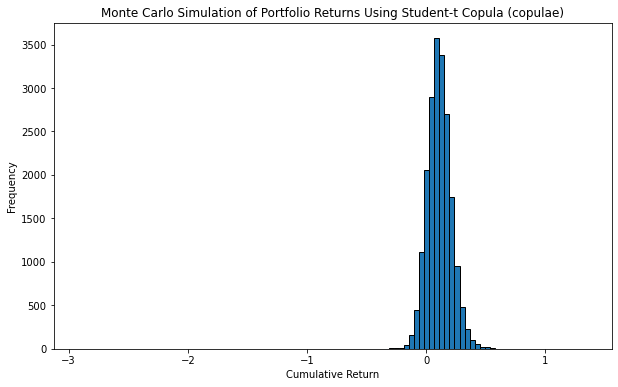

Value at Risk (95% confidence): -4.38%
Expected Annual Return: 10.97%
Annual Standard Deviation: 10.37%


In [15]:
plt.figure(figsize=(10, 6))
plt.hist(cumulative_returns, bins=100, edgecolor='black')
plt.title('Monte Carlo Simulation of Portfolio Returns Using Student-t Copula (copulae)')
plt.xlabel('Cumulative Return')
plt.ylabel('Frequency')
plt.show()

VaR_95 = np.percentile(cumulative_returns, 5)
expected_return = np.mean(cumulative_returns)
std_dev = np.std(cumulative_returns)

print(f"Value at Risk (95% confidence): {VaR_95:.2%}")
print(f"Expected Annual Return: {expected_return:.2%}")
print(f"Annual Standard Deviation: {std_dev:.2%}")